# Rendimiento espacial de la evapotranspiración
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __2/1/2020__

__Introducción__<br>
Se genera el código para aplicar la métrica de rendimiento de un modelo hidrólogico SPAEF [(Koch et al., 2018)](http://doi.org/10.5194/gmd-11-1873-2018). Es una función objetivo que analiza espacialmente el rendimiento del modelo y que emula la lógica detrás del criterio KGE (Kling-Gupta efficiency) [(Gupta et al., 2009)](https://www.sciencedirect.com/science/article/pii/S0022169409004843?via%3Dihub), utilizado habitualmente para el caudal.

$$SPAEF=1-\sqrt{(\alpha-1)^2+(\beta-1)^2+(\gamma-1)^2}$$
Donde $\alpha$ es el coeficiente de correlación de Pearson, $\beta$ el cociente entre los coeficientes de variación (representativo de la variabilidad espacial), y $\gamma$ es la intersección entre los histogramas normalizados del patrón observado ($K$) y del patrón simulado ($L$):
$$\alpha=\rho(obs,sim)
\;,\;\;
\beta=\frac{\frac{\sigma_{sim}}{\mu_{sim}}}{\frac{\sigma_{obs}}{\mu_{obs}}}
\;,\;\;
\gamma=\frac{\sum_{j=1}^{n}min(K_j,L_j)}{\sum_{j=1}^{n}K_j}$$

Como caso de estudio al que aplicar el código se utilizan los resultados de la simulación de la evapotranspiración en la cuenca alta del río Deva.

<font color='indianred'>__Limitación__: compara el acuerdo entre dos mapas, no entre dos series de mapas. Es decir, hay que obtener un mapa medio representativo de la variable. </font>

__Cosas que arreglar__ <br>
*  No se puede guardar el netCDF diario de TETIS en GitHub
*  Añadir función SPAEF desde el [repositorio original en GitHub](https://github.com/casadoj/spaef)

__Cosas a añadir__<br>
Otras posible mediciones del rendimento:
*  Conectividad [(Koch et al., 2018)](http://doi.org/10.5194/gmd-11-1873-2018).
*  _Fraction skill score_ [(Koch et al., 2018)](http://doi.org/10.5194/gmd-11-1873-2018).
*  EOF, _empirical orthogonal functions_ [(Koch et al., 2015)](http://doi.org/10.1002/2014WR016259), (Echevarria-Martinez et al., 2019)

__Referencias__<br>
<font color='gray'>Echeverria-Martínez, C. A., Puertes Castellano, C., Ruiz-Pérez, G., Barrett, B., & Francés, F. (2019). Evaluación de la robustez de la implementación de un modelo hidrológico mediante la calibración con humedad del suelo superficial obtenida por teledetección. In Jornadas de Ingeniería del Agua (pp. 1–17).
    
<font color='gray'>Gupta, H. V., Kling, H., Yilmaz, K. K., & Martinez, G. F. (2009). Decomposition of the mean squared error and NSE performance criteria: Implications for improving hydrological modelling. Journal of Hydrology, 377(1–2), 80–91. http://doi.org/10.1016/J.JHYDROL.2009.08.003

<font color='gray'>Koch, J., Demirel, M. C., & Stisen, S. (2018). The SPAtial EFficiency metric (SPAEF): Multiple-component evaluation of spatial patterns for optimization of hydrological models. Geoscientific Model Development, 11(5), 1873–1886. http://doi.org/10.5194/gmd-11-1873-2018

<font color='gray'>Koch, J., Jensen, K. H., & Stisen, S. (2015). Toward a true spatial model evaluation in distributed hydrological modeling: Kappa statistics, Fuzzy theory, and EOF-analysis benchmarked by the human perception and evaluated against a modeling case study. Water Resources Research, 51, 9127–9140. http://doi.org/10.1002/2014WR016259



***

__Índice__ <br>
__[1 Configuración](#1-Configuración)__<br>

__[2 Datos](#2-Datos)__<br>
[2.1 Cartografía](#2.1-Cartografía)<br>
[2.1 MODIS](#2.1-MODIS)<br>
[2.2 Evapotranspiración](#2.2-Evapotranspiración)<br>

__[3 Tratamiento de datos](#3-Tratamiento-de-datos)__<br>
[3.1 Periodo de estudio](#3.1-Correcciones)<br>
[3.2 Unificar resolución de los mapas](#3.2-Unificar-resolución-de-los-mapas)<br>
[3.3 Agregar serie diaria de TETIS](#3.3-Agregar-serie-diaria-de-TETIS)<br>

__[4 Análisis](#4-Análisis)__<br>
[4.1 Visual](#4.1-Visual)<br>
[4.2 Rendimiento](#4.2-Rendimiento)<br>

In [1]:
import numpy as np
import pandas as pd

import calendar
from datetime import datetime, timedelta
from netCDF4 import Dataset
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'
print(rutaBase)

C:/Users/jcr693/Documents/GitHub/Calibrar/ET/notebooks/


In [2]:
os.chdir(rutaBase + '../../py/')
from funciones_rendimiento_espacial import *
from funciones_raster import *
from funciones_rendimiento import NSE
os.chdir(rutaBase)

In [3]:
#%run funciones_rendimiento_espacial.ipynb

In [4]:
os.chdir(rutaBase + '../../../MODIS/py/')
os.getcwd()

'C:\\Users\\jcr693\\Documents\\GitHub\\MODIS\\py'

In [5]:
os.chdir(rutaBase + '../../../MODIS/py/')
from funciones_MODIS import *
from funciones_EOF import *
os.chdir(rutaBase)

In [6]:
#os.chdir(rutaBase + '..')
#from read_write import read_ascii, write_ascii

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

import seaborn as sns
sns.set()
#custom_style = {'axes.facecolor': 'k',
#                'axes.edgecolor': 'gray',
#                'axes.labelcolor': 'white',
#                'figure.facecolor': 'k',
#                'grid.color': 'gray',
#                'text.color': 'white',
#                'xtick.color': 'white',
#                'ytick.color': 'white',
#                "xtick.major.size": 0,
#                "ytick.major.size": 0}
#sns.set_style(style='darkgrid', rc=custom_style)

In [36]:
def mapaColor(dict, cmap, n_colors, r=10):
    """Crea un mapa de color discreto
    
    Entradas:
    ---------
    dict:     Diccionario que contiene los raster3D a graficar
    cmap:     string. Mapa de color de matplotlib
    n_colors: int. Número de clases
    r:        float. Redondeo del valor máximo
    
    Salidas:
    --------
    CMAP
    norm
    """
    
    # mapa de color
    cmap_colors = cm.get_cmap(cmap, n_colors)
    colors = cmap_colors(np.linspace(0, 1, n_colors))
    CMAP = ListedColormap(colors)
    Max = np.ceil(np.max([np.nanmax(dict[key].data) for key in dict]) / r) * r
    boundaries = np.linspace(0, Max, num=n_colors+1, endpoint=True)
    norm = BoundaryNorm(boundaries, CMAP.N, clip=True)
    
    return CMAP, norm

***
## 1 Configuración

In [8]:
var = 'ET'
varTETIS = 'Y1'

In [9]:
rutaExport = rutaBase + '../output/'
if os.path.exists(rutaExport) is False:
    os.makedirs(rutaExport)

***
## 2 Datos
### 2.1 Cartografía

In [10]:
# ruta cartografía
#rutaGIS = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Proyectos/IAHR2020/GIS/'
rutaGIS = os.path.join(rutaBase, '../../data/GIS/')

# importar polígonos de las cuencas
cuenca = gpd.read_file(rutaGIS + "mask_465_deva.shp")

# importar mdt de la cuenca
DEM = read_ascii(rutaGIS + 'dem_465_deva.asc', crs=25830)
DEM.variable = 'elevación'
DEM.units = 'm.s.n.m'

In [31]:
# definir límites del mapa
cellsize = np.mean(np.diff(DEM.X))
xmin, ymin, xmax, ymax = cuenca.bounds.values[0]
xmin -= cellsize * 2
ymin -= cellsize * 2
xmax += cellsize * 2
ymax += cellsize * 2
extent = [xmin, xmax, ymin, ymax]

### 2.2 Evapotranspiración

#### 2.2.1 MODIS

In [61]:
# fijar ruta y nombre del archivo
rutaData = rutaBase + '../data/'
filename = 'Aqua+Terra_' + var + '_500m_Deva.nc'
MODIS = netCDF2MODIS(rutaData + filename, label='ET')

#### 2.2.2 TETIS

In [62]:
# fijar rutas y nombre del archivo
rutaData = rutaBase + '../data/'
filename = 'TETIS_' + var + '_100m.nc'
TETIS = netCDF2MODIS(rutaData + filename)

print('TETIS:\t{0}'.format(TETIS.data.shape))

TETIS:	(3653, 216, 222)


## 3 Tratamiento de datos
### 3.1 Periodo de estudio
Se seleccionan los datos correspondientes al periodo en el que ambas fuentes (Terra y TETIS) tienen datos.

In [23]:
# fechas de inicio y fin en el que hay datos de ambas fuentes
dateMin = max(MODIS.times.min(), TETIS.times.min())
dateMax = min(MODIS.times.max(), TETIS.times.max())
print('fecha de inicio:\t{0}\nfecha de fin:\t\t{1}'.format(dateMin, dateMax))

fecha de inicio:	2001-01-01
fecha de fin:		2004-09-29


In [14]:
# recortar series al periodo de estudio
MODIS.extraer(dateMin, dateMax, axis=0, inplace=True)
TETIS.extraer(dateMin, dateMax, axis=0, inplace=True)

# dimensiones de las series 8 diarias
print('dimensiones MODIS:\t{0}'.format(MODIS.data.shape))
print('dimensiones TETIS:\t{0}'.format(TETIS.data.shape))

### 3.2 Unificar resolución de los mapas
<font color='indianred'>¿Es mejor aumentar la resolución de MODIS o reducir la de TETIS?</font><br>
Genero una nueva fuente (primera 'key' del diccionario) en la que guardar los resultados de TETIS remuestreados para concordar con la resolución de los mapas de MODIS.

In [17]:
# máscara de la cuenca
mask = DEM.data.mask[:-1,:-1]
mask.shape

(45, 46)

No coinciden las dimensiones X e Y de DEM y MODIS. MODIS tiene una fila y una columna más.

In [18]:
TETIS.remuestrear(MODIS, mask, inplace=True)

# dimensiones de las series 8 diarias
print('dimensiones MODIS:\t{0}'.format(MODIS.data.shape))
print('dimensiones TETIS:\t{0}'.format(TETIS.data.shape))

### 3.3 Agregar serie diaria de TETIS
#### Serie 8 diaria

In [21]:
# agregar datos a 8 días
TETIS8d = TETIS.agregar(w=8, agg='sum')

# dimensiones de las series 8 diarias
print('dimensiones MODIS:\t{0}'.format(MODIS.data.shape))
print('dimensiones TETIS:\t{0}'.format(TETIS8d.data.shape))

ET8d = {'MODIS': MODIS, 'TETIS': TETIS8d}

#### Serie mensual

In [24]:
# generar series mensuales
MODISsm = serieMensual(MODIS, agg='sum')
TETISsm = serieMensual(TETIS, agg='sum')

# dimensiones de las series mensuales
print('dimensiones MODIS:\t{0}'.format(MODISsm.data.shape))
print('dimensiones TETIS:\t{0}'.format(TETISsm.data.shape))

ETsm = {'MODIS': MODISsm, 'TETIS': TETISsm}

#### Medias mensuales

In [41]:
# generar medias mensuales
MODISmm = mediaMensual(MODISsm)
TETISmm = mediaMensual(TETISsm)

# dimensiones de las medias mensuales
print('dimensiones MODIS:\t{0}'.format(MODISmm.data.shape))
print('dimensiones TETIS:\t{0}'.format(TETISmm.data.shape))

ETmm = {'MODIS': MODISmm, 'TETIS': TETISmm}

dimensiones MODIS:	(12, 45, 46)
dimensiones TETIS:	(12, 45, 46)


C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_MODIS.py:773: RuntimeWarning: Mean of empty slice
  meanM[m,:,:] = np.nanmean(modis.data[ks,:,:], axis=0)


***
## 4 Análisis
1. <font color='steelblue'>Generar mapas medios</font>. Probaría inicialmente con un mapa medio de junio, al igual que hace Koch (2018). Aunque el número de mapas de las dos fuentes es el mismo, las fechas no coinciden, con lo que no es posible comparar mapa contra mapa.
2. <font color='steelblue'>Normalizar mapas</font>. Necesario para comparar dos mapas que puedan tener diferentes magnitudes
3. <font color='steelblue'>Analizar SPAEF</font>

### 4.1 Visual

#### Serie 8 diaria

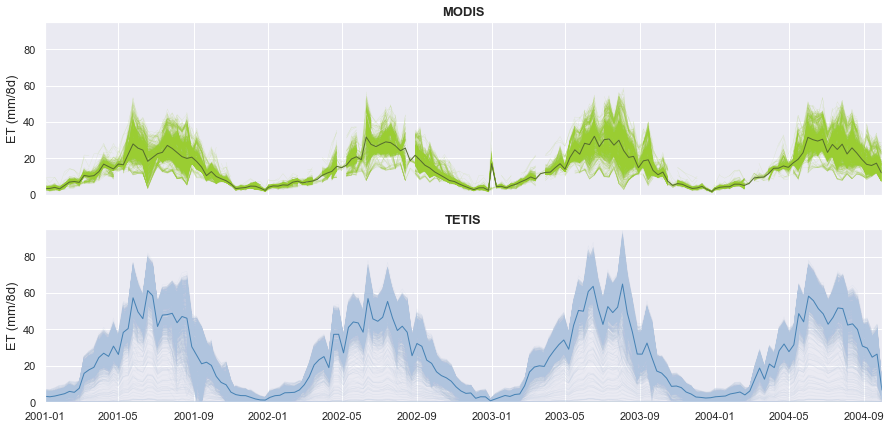

In [29]:
plotMODISseries(ET8d, r=5, alpha=.25, ylabel=var + ' (mm/8d)')
plt.savefig(rutaExport + 'Comparativa series 8 diarias.png', dpi=300)

Exportando archivo C:/Users/jcr693/Documents/GitHub/Calibrar/ET/notebooks/../output/ET_MODIS_vs_TETIS_8d.mp4


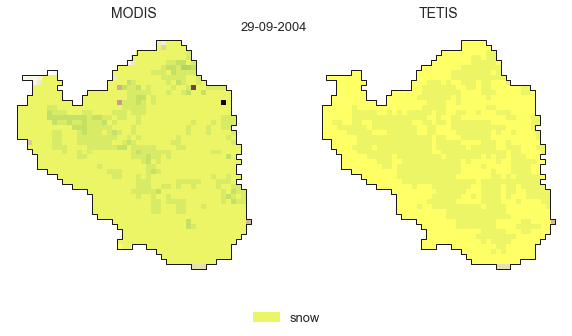

In [35]:
# vídeo comparativo 
cmap_8d, norm_8d = mapaColor(ET8d, 'summer_r', 14, r=10)
mp4File = rutaExport + 'ET_MODIS_vs_TETIS_8d.mp4'
video2(ET8d['MODIS'], ET8d['TETIS'], cuenca, cmap_8d, norm_8d, DEM, fps=1, dpi=150, ax=None,
       figsize=(10, 5), extent=extent, labels=['MODIS', 'TETIS'], export=mp4File)

Los mapas originales de MODIS contienen numerosos huecos, lo que hace complicado la comparación con los mapas simulados con TETIS, en los que no hay huecos.

#### Serie mensual

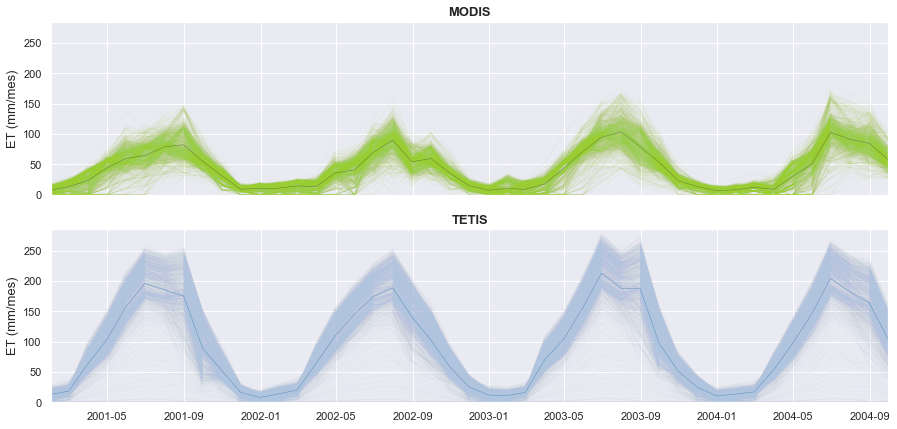

In [38]:
plotMODISseries(ETsm, r=5, alpha=.25, lw=.1, ylabel=var + ' (mm/mes)')
plt.savefig(rutaExport + 'Comparativa series mensuales.png', dpi=300)

Exportando archivo C:/Users/jcr693/Documents/GitHub/Calibrar/ET/notebooks/../output/ET_MODIS_vs_TETIS_mensual.mp4


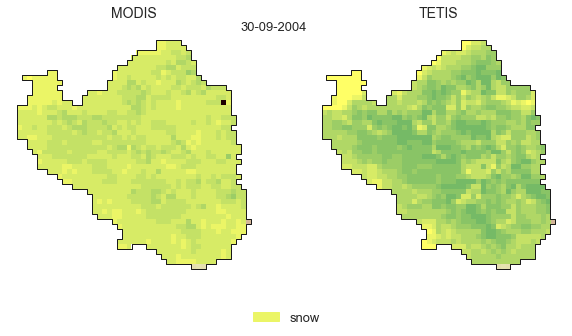

In [39]:
# vídeo
cmap_sm, norm_sm = mapaColor(ETsm, 'summer_r', 14, r=10)
mp4File = rutaExport + 'ET_MODIS_vs_TETIS_mensual.mp4'
video2(ETsm['MODIS'], ETsm['TETIS'], cuenca, cmap_sm, norm_sm, DEM, fps=1, dpi=150, ax=None,
       figsize=(10, 5), extent=extent, labels=['MODIS', 'TETIS'], export=mp4File)

Se simula un exceso de evapotranspiración en verano y un ligero adelanto de la época de crecimiento vegetativo en la primavera.

#### Medias mensuales

<ipython-input-42-a45e4782bfaf>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(monthnames[::2])
<ipython-input-42-a45e4782bfaf>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(monthnames[::2])


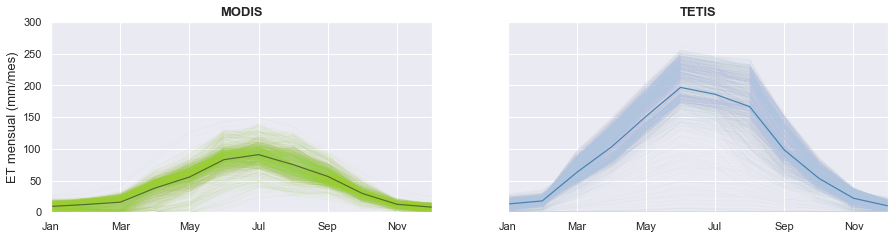

In [42]:
# mostrar la media mensual para cada celda y la media de la cuenca
fig, axes = plt.subplots(ncols=2, figsize=(15, 3.5), sharey=True)

r = 50
ymax = np.ceil(max([np.nanmax(ETmm[key].data) for key in ETmm]) / r) * r
colors = [['yellowgreen', 'darkolivegreen'], ['lightsteelblue', 'steelblue']]

for c, (ax, src) in enumerate(zip(axes, ETmm)):
    meanMx = ETmm[src].data
    for i in range(meanMx.shape[1]):
        for j in range(meanMx.shape[2]):
            if np.isnan(meanMx[:,i,j]).sum() == meanMx.shape[0]: # celda vacía
                continue
            else:
                ax.plot(meanMx[:,i,j], lw=.1, c=colors[c][0], alpha=.25)
    ax.plot(np.nanmean(meanMx, axis=(1, 2)), c=colors[c][1], lw=1.2)
    ax.tick_params(labelsize=11)
    ax.set(xlim=(0, 11), ylim=(0, ymax))
    if c == 0:
        ax.set_ylabel(var + ' mensual (mm/mes)', fontsize=13);
    monthnames = [datetime(1900, m, 1).strftime('%b') for m in range(1, 13)]
    ax.set_xticklabels(monthnames[::2])
    ax.set_title(src, fontsize=13, fontweight='bold')

In [43]:
print('ETmedia (Terra):\t{0:.1f} mm'.format(np.nanmean(ETmm['MODIS'].data) *12))
print('ETmedia (TETIS):\t{0:.1f} mm'.format(np.nanmean(ETmm['TETIS'].data) * 12))

ETmedia (Terra):	487.4 mm
ETmedia (TETIS):	1081.7 mm


En la figura superior se comprueba claramente cómo la simulación sobrevalora la evapotranspiración. La evapotranspiración media de TETIS (1041.2 mm) la observada por MODIS (480 mm).

#### Mapa medio de junio

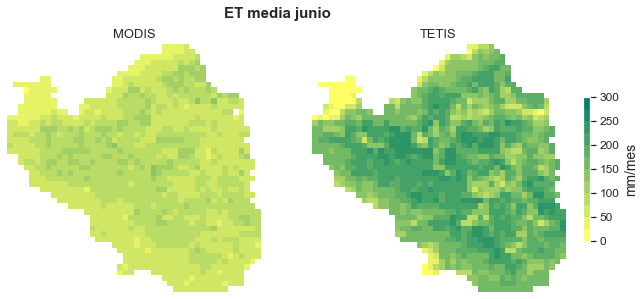

In [45]:
t = 7

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.subplots_adjust(right=0.9)

cmap_mm, norm_mm = mapaColor(ETmm, 'summer_r', 12, r=50)

for ax, src in zip(axes, ETmm):
    im = ax.imshow(ETmm[src].data[t,:,:], cmap=cmap_mm, norm=norm_mm)
    ax.set_title(src, fontsize=13)
    ax.axis('off')
    
cbar_ax = fig.add_axes([0.925, 0.3, 0.01, 0.4])
cbar_ax.tick_params(labelsize=12)
cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
cb.set_label('mm/mes', fontsize=14)
    
fig.text(0.5, .92, 'ET media junio', fontsize=15, fontweight='bold', horizontalalignment='center');

### 4.2 Rendimiento
#### KGE & SPAEF

##### Serie 8 diaria

KGE = -1.040
SPAEF = -0.332


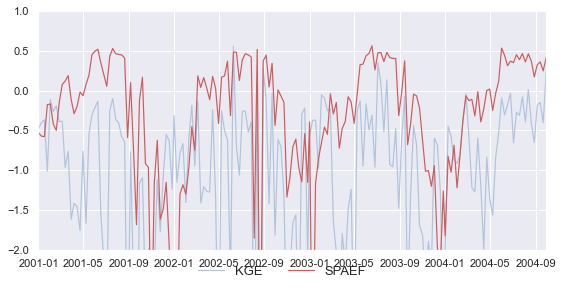

In [47]:
R8d = rend_espacial(MODIS.times, MODIS.data, TETIS8d.data)

for OF in R8d.columns:
    print('{0} = {1:.3f}'.format(OF, R8d[OF].mean()))

#### Serie mensual

KGE = -0.744
SPAEF = 0.272


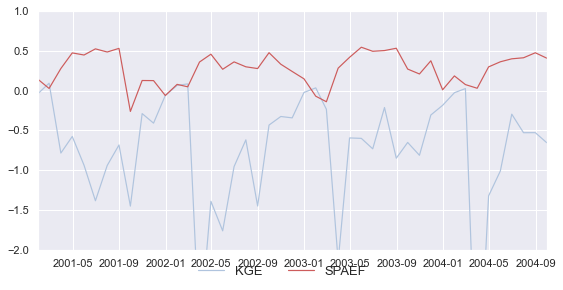

In [48]:
Rsm = rend_espacial(MODISsm.times, MODISsm.data, TETISsm.data)

for OF in Rsm.columns:
    print('{0} = {1:.3f}'.format(OF, Rsm[OF].mean()))

Se comprueba el mismo comportamiento indicado para la media mensual. El SPAEF tiene una mayor variabilidad (rango de variación) que el KGE. Ambas métricas tienen un ciclo anual con mejor rendimiento en los veranos y peor rendimiento en los inviernos.
#### Medias mensuales

KGE = -0.779
SPAEF = 0.362


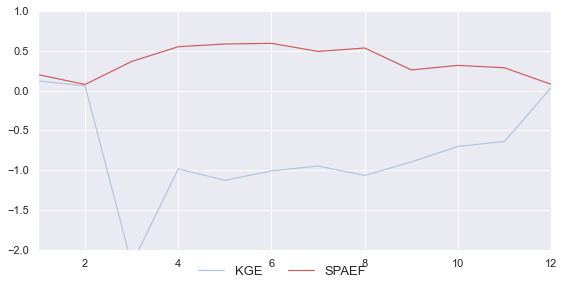

In [49]:
Rmm = rend_espacial(MODISmm.times, MODISmm.data, TETISmm.data)

for OF in Rmm.columns:
    print('{0} = {1:.3f}'.format(OF, Rmm[OF].mean()))

Se observa una mayor sensibilidad del SPAEF que del KGE. El SPAEF toma valores muy bajos en febrero y noviembre, y varlores relativamente buenos de junio a agosto. Por el contrario, el KGE tiene valores relativamente constantes entre -0.5 y 0 durante todo el año, aun también con valores ligeramente mejores en el verano.

#### Sesgo: $\rho$
El sesgo no está incluido en la definición de SPAEF de [(Koch et al., 2018)](https://www.geosci-model-dev.net/11/1873/2018/). En parte en ellos obvian el sesgo porque comparan dos variables relacionadas, pero con unidades distintas (calor latente y evapotranspiración).

En el caso de TETIS y MODIS, la variables y las unidades son las mismas: evapotranspiración en mm. Por tanto, es posible, y considero que conveniente, estimar el sesgo entre observación y simulación para asegurar un correcto balance hídrico.

Además, el sesgo nos permitirá calcular el KGE.

In [50]:
S = np.nansum(aux_, axis=1)
rho = (S[1] - S[0]) / S[0]
print('rho = {0:.3f}'.format(rho))

NameError: name 'aux_' is not defined

#### EOF

In [51]:
EOF = {key: {} for key in ETsm}

In [52]:
# nº de modos de la EOF a extraer
nmodes = 4

C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_EOF.py:112: UserWarning: No contour levels were found within the data range.
  ax.contour(eofmap[i,:,:], np.linspace(mapmin, mapmax, 5), colors='k', linewidths=.5)


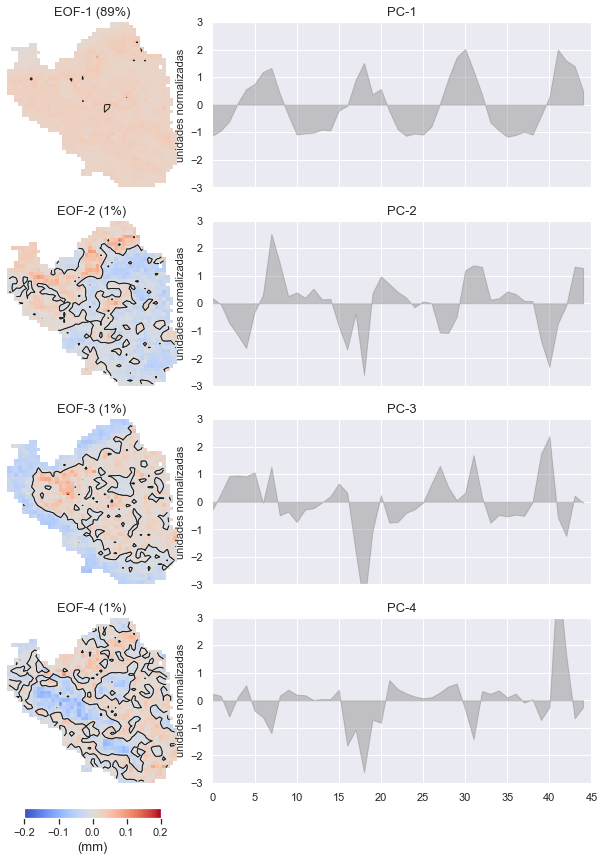

In [53]:
eofMODIS(MODISsm, nmodes, plot='eofs')

EOF['MODIS']['eofM'] = eofMODIS.eofs
EOF['MODIS']['pcM'] = eofMODIS.pcs
EOF['MODIS']['corrM'] = eofMODIS.correlation
EOF['MODIS']['varM'] = eofMODIS.explainedVariance
EOF['MODIS']['fvarM'] = eofMODIS.fractionVariance
plt.savefig(rutaExport + var + ' eofs-MODIS serie mensual.png', dpi=300)

C:\ProgramFiles\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramFiles\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


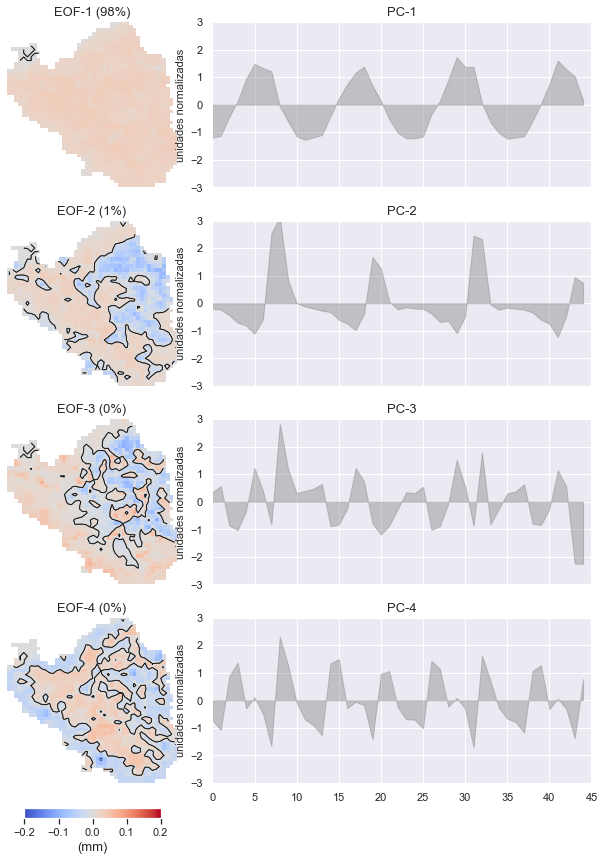

In [54]:
eofMODIS(TETISsm, nmodes, plot='eofs')

EOF['TETIS']['eofM'] = eofMODIS.eofs
EOF['TETIS']['pcM'] = eofMODIS.pcs
EOF['TETIS']['corrM'] = eofMODIS.correlation
EOF['TETIS']['varM'] = eofMODIS.explainedVariance
EOF['TETIS']['fvarM'] = eofMODIS.fractionVariance
plt.savefig(rutaExport + var + ' eofs-TETIS serie mensual.png', dpi=300)

In [55]:
# 'data frame' con el rendimiento de los PC
# NSE: Nash-Sutclifee efficiency; SAE: sum of absolute error
rendPC = pd.DataFrame(index=range(nmodes), columns=['NSE', 'SAE'])
for i in range(nmodes):
    obs = pd.Series(EOF['MODIS']['pcM'][:,i], ETsm['MODIS'].times)
    sim = pd.Series(EOF['TETIS']['pcM'][:,i], ETsm['TETIS'].times)
    rendPC.loc[i, 'NSE'] = NSE(obs, sim)
    rendPC.loc[i, 'SAE'] = np.sum(np.abs(obs - sim))
    
# mNSE: mean Nash-Sutcliffe efficiency
mNSE = rendPC.NSE.mean()
# wSAE: weighted sum absolute error
w = EOF['MODIS']['fvarM'][:nmodes] / EOF['MODIS']['fvarM'][:nmodes].sum()
wSAE = (w * rendPC.SAE).sum()
# wNSE: weighted Nahs-Sutcliffe efficiency
wNSE = (w * rendPC.NSE).sum()

print('mNSE = {0:.3f}\t wSAE = {1:.0f}\twNSE = {2:.3f}'.format(mNSE, wSAE, wNSE))

mNSE = -0.814	 wSAE = 50226	wNSE = -0.803


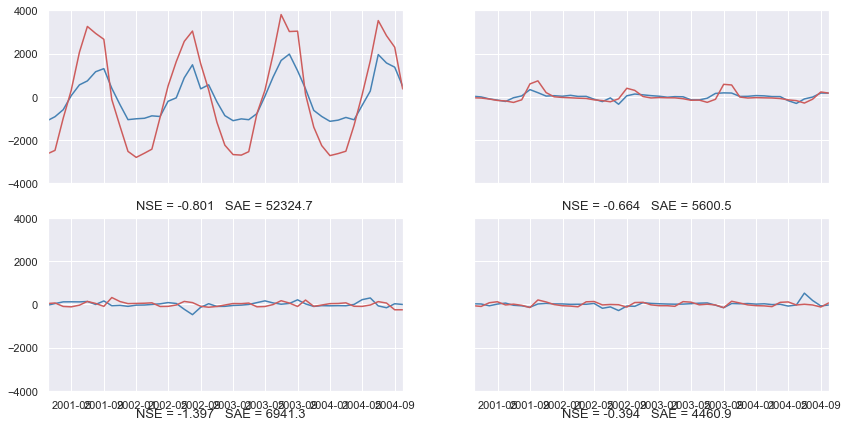

In [56]:
# calcular NSE entre los PCs observado y simulado
ncols = 2
nrows = ceil(nmodes / 2)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows*3.5),
                         sharex=True, sharey=True)

for i in range(nmodes):
    f, c = int(i / ncols), i % ncols
    obs = pd.Series(EOF['MODIS']['pcM'][:,i], ETsm['MODIS'].times)
    sim = pd.Series(EOF['TETIS']['pcM'][:,i], ETsm['TETIS'].times)
    ax[f,c].plot(obs, c='steelblue')
    ax[f,c].plot(sim, c='indianred')
    ax[f,c].text(0.25, -.15, 'NSE = {0:.3f}'.format(rendPC.loc[i, 'NSE']),
                 transform=ax[f,c].transAxes, fontsize=13)
    ax[f,c].text(0.5, -.15, 'SAE = {0:.1f}'.format(rendPC.loc[i, 'SAE']),
                 transform=ax[f,c].transAxes, fontsize=13)
    
ax[f,c].set_xlim(ETsm['MODIS'].times[0], ETsm['MODIS'].times[-1])
ax[f,c].set_ylim(-4000, 4000);

Las tres métricas anteriores se basan en la comparación entre componentes principales (PCs). Estos son una aproximación a la variabilidad temporal de la variable de estudio, es decir, describen la serie temporal de unos mapas, los EOFs. Por tanto, el rendimiento de estas series temporales asegura una variabilidad adecuada del modelo ajustado, pero el valor de la variable en sí puede adolecer de sesgo si los mapas (EOFs) no coinciden.

Entiendo que sería necesario también comprobar que las EOFs observada y simulada tienen un valor medio (y un patrón espacial) acorde. Aquí aparece de nuevo el dilema de cómo analizar el ajuste entre dos mapas; una posible solución sería aplicar SPAEF o KGE-espacial a los EOFs.

In [57]:
# 'data frame' con el rendimiento de las EOF
# NSE: Nash-Sutclifee efficiency; SAE: sum of absolute error
rendEOF = pd.DataFrame(index=range(nmodes), columns=['SPAEF', 'KGE'])
for i in range(nmodes):
    print('Componente {0}'.format(i+1))
    obs, sim = EOF['MODIS']['eofM'][i,:,:], EOF['TETIS']['eofM'][i,:,:]
    rendEOF.loc[i, 'KGE'] = KGEsp(obs, sim, plot=False, verbose=True)
    rendEOF.loc[i, 'SPAEF'] = SPAEF(obs, sim, plot=False, verbose=True)
    print()

# mKGE: mean Kling-Gupta efficiency
mKGE = rendEOF.KGE.mean()
# wKGE: weighted Kling-Gupta efficiency
w = EOF['MODIS']['fvarM'][:nmodes] / EOF['MODIS']['fvarM'][:nmodes].sum()
wKGE = (w * rendEOF.KGE).sum()
# mSPAEF: mean spatial efficiency
mSPAEF = rendEOF.SPAEF.mean()
# wNSE: weighted spatial efficiency
wSPAEF = (w * rendEOF.SPAEF).sum()

print('mKGE = {0:.3f}\twKGE = {1:.3f}\tmSPAEF = {2:.3f}\twSPAEF = {3:.3f}'.format(mKGE,
                                                                                  wKGE,
                                                                                  mSPAEF,
                                                                                  wSPAEF))

Componente 1
rho = 0.577	alpha = 1.259	beta = 0.987
KGEsp = 0.504
rho = 0.577	gamma = 1.275	delta = 0.813
SPAEF = 0.462

Componente 2
rho = 0.325	alpha = 0.998	beta = 2.182
KGEsp = -0.361
rho = 0.325	gamma = 0.457	delta = 0.647
SPAEF = 0.065

Componente 3
rho = -0.279	alpha = 0.995	beta = -1.975
KGEsp = -2.238
rho = -0.279	gamma = -0.504	delta = 0.877
SPAEF = -0.978

Componente 4
rho = -0.158	alpha = 0.998	beta = 3.064
KGEsp = -1.367
rho = -0.158	gamma = 0.326	delta = 0.787
SPAEF = -0.356

mKGE = -0.866	wKGE = 0.423	mSPAEF = -0.202	wSPAEF = 0.422


Parece obvio que es necesario dar más peso a los componentes de las EOF que explican una mayor parte de la varianza. De este modo se evitan casos como el _mKGE_, en el que se obtiene un valor medio muy pobre a pesar de que el primer componente tiene un KGE aceptable.